In [2036]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2037]:
# !pip install shap

### Import all required libraries and modules

In [2038]:
import os 
import sys
import shap
from scipy.stats import shapiro, norm, mannwhitneyu
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# sys.path.append("/Users/nikolaynechay/Iris-Species")
sys.path.append("/home/nikolay/Deloitte/project_task/Iris")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2039]:
from src.core.helpers.model_evaluation import evaluate_model
from src.core.helpers.error_analysis import analyse_logits_in_incorrect_predictions, create_detailed_analysis, calculate_main_statistics, analyse_contributions_in_incorrect_predictions, analyze_classification_errors_simple
from src.core.helpers.ea_hist_by_target import plot_error_distribution
from src.core.helpers.visualizations import plot_distribution_of_logits
from src.core.helpers.confusion_matrix_for_missclassifications import plot_confusion_matrix_for_miss_classifications

from src.core.helpers.calculate_boundaries import boundaries
from src.core.helpers.delete_outliers import delete_outliers
from src.core.helpers.feature_engineering import generate_top_features

In [2040]:
# os.chdir("/Users/nikolaynechay/Iris-Species")

# Data Collection

### Setting required Global Variables

In [2041]:
# IRIS_PATH="src/core/datafiles/raw/Iris.csv"
IRIS_PATH="/home/nikolay/Deloitte/project_task/Iris/src/core/datafiles/raw/Iris.csv"

### Load dataset

In [2042]:
iris_df = pd.read_csv(IRIS_PATH)
iris_df.drop('Id', axis=1, inplace=True)  # Delete ID column
display(iris_df.head().style.background_gradient(cmap='Greys'))

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.100000,3.500000,1.400000,0.200000,Iris-setosa
1,4.900000,3.000000,1.400000,0.200000,Iris-setosa
2,4.700000,3.200000,1.300000,0.200000,Iris-setosa
3,4.600000,3.100000,1.500000,0.200000,Iris-setosa
4,5.000000,3.600000,1.400000,0.200000,Iris-setosa


In [2043]:
# print(f"Number of duplicates in data: {iris_df.duplicated().sum()}")
# iris_df.drop_duplicates(inplace=True)
# print(f"Number of duplicates in data: {iris_df.duplicated().sum()}")

# for feature in iris_df.columns[:-1]:
#     lower_bound, upper_bound = boundaries(iris_df[feature])
#     if lower_bound is not None and upper_bound is not None:
#         iris_df = delete_outliers(iris_df, feature, lower_bound, upper_bound)

# Feature Engineering

In [2044]:
new_df = generate_top_features(iris_df, target_column='Species', k=4)
new_df.head()

,PetalLengthCm,SepalLengthCm/PetalLengthCm,PetalLengthCm/SepalLengthCm,PetalWidthCm/SepalWidthCm,Species
0,1.4,3.642857,0.274510,0.057143,Iris-setosa
1,1.4,3.500000,0.285714,0.066667,Iris-setosa
2,1.3,3.615385,0.276596,0.062500,Iris-setosa
3,1.5,3.066667,0.326087,0.064516,Iris-setosa
4,1.4,3.571429,0.280000,0.055556,Iris-setosa


# Model building

In [2045]:
# Split data into train and test sets
label_encoder = LabelEncoder()
# scaler = StandardScaler()
# normalized_df = iris_df.copy()
# normalized_df[normalized_df.columns[:-1]] = scaler.fit_transform(normalized_df[normalized_df.columns[:-1]])
def compress_boundary_region(x, lower_bound=4.0, upper_bound=5.5, compression_factor=0.3):
    return np.where(
        (x >= lower_bound) & (x <= upper_bound),
        lower_bound + (x - lower_bound) * compression_factor,
        x 
    )

# mask_versicolor = iris_df['Species'] == 'Iris-versicolor'
# iris_df.loc[mask_versicolor, 'PetalLengthCm'] = compress_boundary_region(
#     iris_df.loc[mask_versicolor, 'PetalLengthCm'],
#     lower_bound=3.0,
#     upper_bound=5.0
# )

# mask_virginica = iris_df['Species'] == 'Iris-virginica'
# iris_df.loc[mask_virginica, 'PetalLengthCm'] = compress_boundary_region(
#     iris_df.loc[mask_virginica, 'PetalLengthCm'],
#     lower_bound=4.5,
#     upper_bound=7.0
# )

X, y = iris_df.drop('Species', axis=1), iris_df['Species']
X_new, y_new = new_df.drop('Species', axis=1), new_df['Species']
# X['PetalLengthCm'] = compress_boundary_region(X['PetalLengthCm'])
# X['PetalLengthCm'] = X['PetalLengthCm'].map(lambda x: np.log(x + 1))
# X['PetalLengthCm'] = np.sqrt(X['PetalLengthCm'])
y = label_encoder.fit_transform(y)
y_new = label_encoder.fit_transform(y_new)
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=0.2,
    random_state=41,
    stratify=y
)

X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(
    X_new,y_new,
    test_size=0.2,
    random_state=41,
    stratify=y_new
)
X_new.head()

,PetalLengthCm,SepalLengthCm/PetalLengthCm,PetalLengthCm/SepalLengthCm,PetalWidthCm/SepalWidthCm
0,1.4,3.642857,0.274510,0.057143
1,1.4,3.500000,0.285714,0.066667
2,1.3,3.615385,0.276596,0.062500
3,1.5,3.066667,0.326087,0.064516
4,1.4,3.571429,0.280000,0.055556


In [2046]:
# build baseline logistic regression model
baseline_logistic_regression_model = LogisticRegression(max_iter=50, random_state=42)
baseline_logistic_regression_model.fit(X_train, y_train)

baseline_train_df_with_predictions, baseline_train_accuracy, baseline_train_precision, baseline_train_recall, baseline_train_f1 = evaluate_model(X_train, y_train, baseline_logistic_regression_model)
baseline_test_df_with_predictions, baseline_test_accuracy, baseline_test_precision, baseline_test_recall, baseline_test_f1 = evaluate_model(X_test, y_test, baseline_logistic_regression_model)

print("Baseline model evaluation:")
print(f"Train Accuracy: {baseline_train_accuracy:.4f}")
print(f"Train Precision: {baseline_train_precision:.4f}")
print(f"Train Recall: {baseline_train_recall:.4f}")
print(f"Train F1: {baseline_train_f1:.4f}")
print('---------------------')
print(f"Test Accuracy: {baseline_test_accuracy:.4f}")
print(f"Test Precision: {baseline_test_precision:.4f}")
print(f"Test Recall: {baseline_test_recall:.4f}")
print(f"Test F1: {baseline_test_f1:.4f}")

Baseline model evaluation:
Train Accuracy: 0.9750
Train Precision: 0.9752
Train Recall: 0.9750
Train F1: 0.9750
---------------------
Test Accuracy: 0.9333
Test Precision: 0.9333
Test Recall: 0.9333
Test F1: 0.9333


/home/nikolay/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [2047]:
# build working logistic regression model
working_model = LogisticRegression(max_iter=50, random_state=41)
working_model.fit(X_new_train, y_new_train)

train_df_with_predictions, train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(X_new_train, y_new_train, working_model)
test_df_with_predictions, test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(X_new_test, y_new_test, working_model)

print("Working model evaluation:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train Recall: {train_recall:.4f}")
print(f"Train F1: {train_f1:.4f}")
print('---------------------')
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1: {test_f1:.4f}")

Working model evaluation:
Train Accuracy: 0.9500
Train Precision: 0.9500
Train Recall: 0.9500
Train F1: 0.9500
---------------------
Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


In [2048]:
train_df_with_predictions.head()

,PetalLengthCm,SepalLengthCm/PetalLengthCm,PetalLengthCm/SepalLengthCm,PetalWidthCm/SepalWidthCm,true_label,predicted_label,probability_of_0,probability_of_1,probability_of_2,is_correct
123,4.9,1.285714,0.777778,0.666667,2,2,0.003,0.458,0.539,True
106,4.5,1.088889,0.918367,0.680000,2,1,0.005,0.714,0.281,False
149,5.1,1.156863,0.864407,0.600000,2,2,0.001,0.315,0.684,True
10,1.5,3.600000,0.277778,0.054054,0,0,0.989,0.011,0.000,True
98,3.0,1.700000,0.588235,0.440000,1,1,0.174,0.824,0.001,True


# ER (Error Analysis)



##### Distribution of correct and incorrect predictions on train set

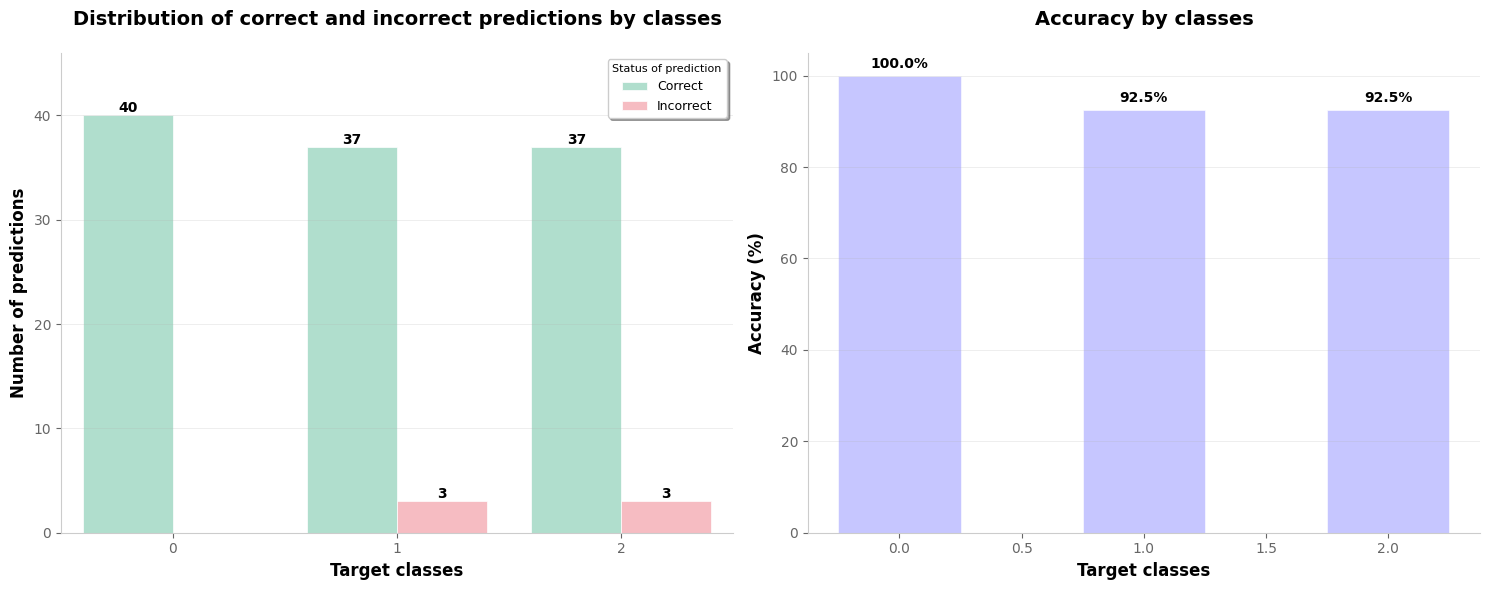

In [2049]:
plot_error_distribution(train_df_with_predictions['predicted_label'], y_new_train)


##### Distribution of correct and incorrect predictions on test set

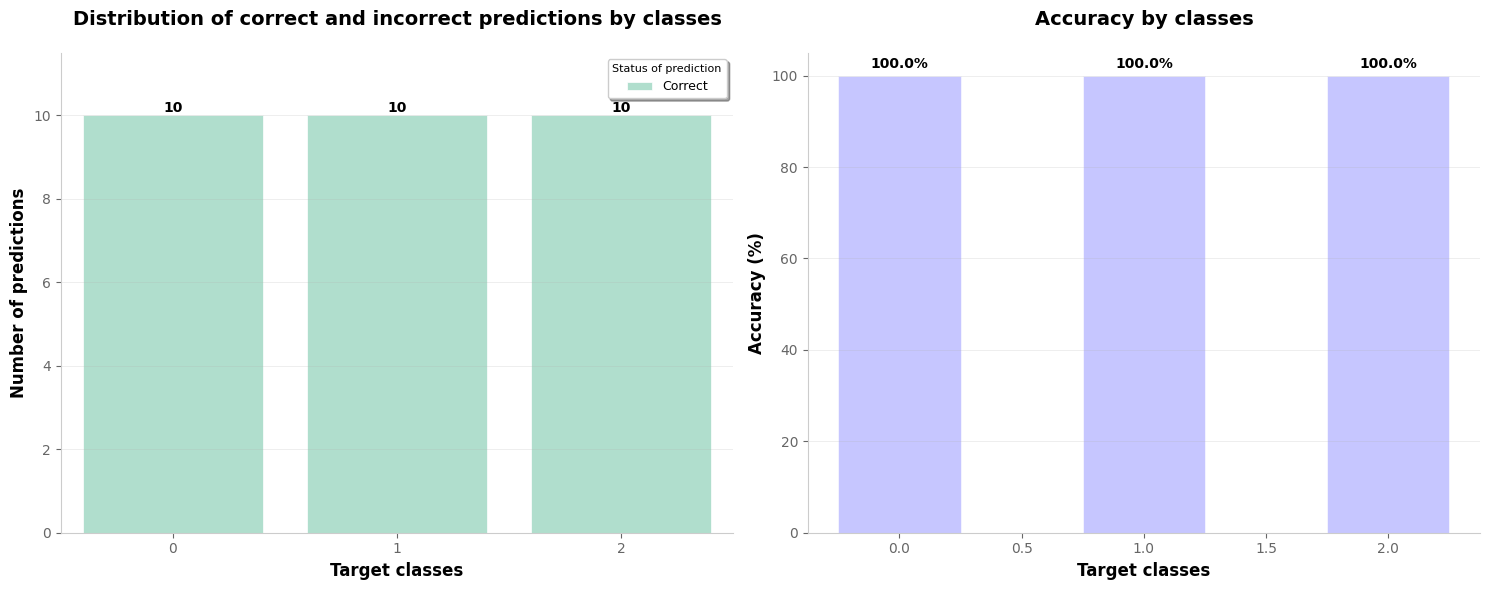

In [2050]:
plot_error_distribution(test_df_with_predictions['predicted_label'], y_new_test)

##### Create dataframe for error classifications on train set

In [2051]:
train_df_errors = train_df_with_predictions[train_df_with_predictions['is_correct'] == False]
train_df_errors.head()

,PetalLengthCm,SepalLengthCm/PetalLengthCm,PetalLengthCm/SepalLengthCm,PetalWidthCm/SepalWidthCm,true_label,predicted_label,probability_of_0,probability_of_1,probability_of_2,is_correct
106,4.5,1.088889,0.918367,0.680000,2,1,0.005,0.714,0.281,False
126,4.8,1.291667,0.774194,0.642857,2,1,0.004,0.549,0.447,False
83,5.1,1.176471,0.850000,0.592593,1,2,0.001,0.322,0.677,False
138,4.8,1.250000,0.800000,0.600000,2,1,0.004,0.562,0.434,False
77,5.0,1.340000,0.746269,0.566667,1,2,0.002,0.436,0.561,False


##### Create dataframe for error classifications on test set

In [2052]:
test_df_errors = test_df_with_predictions[test_df_with_predictions['is_correct'] == False]
test_df_errors.head()

,PetalLengthCm,SepalLengthCm/PetalLengthCm,PetalLengthCm/SepalLengthCm,PetalWidthCm/SepalWidthCm,true_label,predicted_label,probability_of_0,probability_of_1,probability_of_2,is_correct


##### Plot confusion matrix for miss classifications on train set

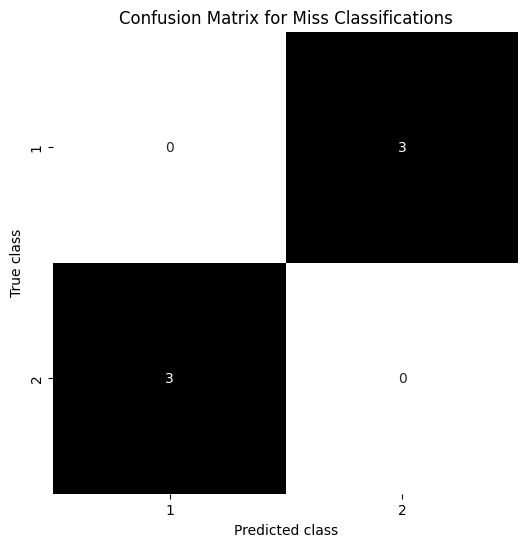

In [2053]:
plot_confusion_matrix_for_miss_classifications(train_df_errors)

##### Plot confusion matrix for miss classifications on test set

In [2054]:
plot_confusion_matrix_for_miss_classifications(test_df_errors)

No miss-classifications to display.


In [2055]:
weights = working_model.coef_
bias = working_model.intercept_
# feature_names = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
feature_names = X_new_train.columns.tolist()

print(f"Weights: {weights}\nBias: {bias}")

Weights: [[-2.03580338  1.49477905 -0.32643421 -0.36355867]
 [-0.58129198 -0.60833621 -0.20692743 -0.78770017]
 [ 2.61709536 -0.88644284  0.53336164  1.15125884]]
Bias: [  5.08576062   5.96682043 -11.05258106]


In [2056]:
train_detailed_df = create_detailed_analysis(train_df_with_predictions, weights, bias, feature_names)
test_detailed_df = create_detailed_analysis(test_df_with_predictions, weights, bias, feature_names)
train_detailed_df.head()

,original_idx,true_label,predicted_label,logit_class_0,probability_class_0,bias_class_0,logit_class_1,probability_class_1,bias_class_1,logit_class_2,probability_class_2,bias_class_2,PetalLengthCm_value,PetalLengthCm_contribution_class_0,PetalLengthCm_weight_class_0,PetalLengthCm_contribution_class_1,PetalLengthCm_weight_class_1,PetalLengthCm_contribution_class_2,PetalLengthCm_weight_class_2,SepalLengthCm/PetalLengthCm_value,SepalLengthCm/PetalLengthCm_contribution_class_0,SepalLengthCm/PetalLengthCm_weight_class_0,SepalLengthCm/PetalLengthCm_contribution_class_1,SepalLengthCm/PetalLengthCm_weight_class_1,SepalLengthCm/PetalLengthCm_contribution_class_2,SepalLengthCm/PetalLengthCm_weight_class_2,PetalLengthCm/SepalLengthCm_value,PetalLengthCm/SepalLengthCm_contribution_class_0,PetalLengthCm/SepalLengthCm_weight_class_0,PetalLengthCm/SepalLengthCm_contribution_class_1,PetalLengthCm/SepalLengthCm_weight_class_1,PetalLengthCm/SepalLengthCm_contribution_class_2,PetalLengthCm/SepalLengthCm_weight_class_2,PetalWidthCm/SepalWidthCm_value,PetalWidthCm/SepalWidthCm_contribution_class_0,PetalWidthCm/SepalWidthCm_weight_class_0,PetalWidthCm/SepalWidthCm_contribution_class_1,PetalWidthCm/SepalWidthCm_weight_class_1,PetalWidthCm/SepalWidthCm_contribution_class_2,PetalWidthCm/SepalWidthCm_weight_class_2,contribution_diff_PetalLengthCm,contribution_diff_SepalLengthCm/PetalLengthCm,contribution_diff_PetalLengthCm/SepalLengthCm,contribution_diff_PetalWidthCm/SepalWidthCm,bias_diff
0,123,2,2,-3.464,0.003,5.086,1.650,0.458,5.967,1.814,0.539,-11.053,4.9,-9.975,-2.036,-2.848,-0.581,12.824,2.617,1.286,1.922,1.495,-0.782,-0.608,-1.140,-0.886,0.778,-0.254,-0.326,-0.161,-0.207,0.415,0.533,0.667,-0.242,-0.364,-0.525,-0.788,0.768,1.151,NaN,NaN,NaN,NaN,NaN
1,106,2,1,-2.995,0.005,5.086,1.963,0.714,5.967,1.032,0.281,-11.053,4.5,-9.161,-2.036,-2.616,-0.581,11.777,2.617,1.089,1.628,1.495,-0.662,-0.608,-0.965,-0.886,0.918,-0.300,-0.326,-0.190,-0.207,0.490,0.533,0.680,-0.247,-0.364,-0.536,-0.788,0.783,1.151,-14.393,0.303,-0.68,-1.318,17.019
2,149,2,2,-4.068,0.001,5.086,1.647,0.315,5.967,2.421,0.684,-11.053,5.1,-10.383,-2.036,-2.965,-0.581,13.347,2.617,1.157,1.729,1.495,-0.704,-0.608,-1.025,-0.886,0.864,-0.282,-0.326,-0.179,-0.207,0.461,0.533,0.600,-0.218,-0.364,-0.473,-0.788,0.691,1.151,NaN,NaN,NaN,NaN,NaN
3,10,0,0,7.303,0.989,5.086,2.805,0.011,5.967,-10.108,0.000,-11.053,1.5,-3.054,-2.036,-0.872,-0.581,3.926,2.617,3.600,5.381,1.495,-2.190,-0.608,-3.191,-0.886,0.278,-0.091,-0.326,-0.057,-0.207,0.148,0.533,0.054,-0.020,-0.364,-0.043,-0.788,0.062,1.151,NaN,NaN,NaN,NaN,NaN
4,98,1,1,1.167,0.174,5.086,2.720,0.824,5.967,-3.888,0.001,-11.053,3.0,-6.107,-2.036,-1.744,-0.581,7.851,2.617,1.700,2.541,1.495,-1.034,-0.608,-1.507,-0.886,0.588,-0.192,-0.326,-0.122,-0.207,0.314,0.533,0.440,-0.160,-0.364,-0.347,-0.788,0.507,1.151,NaN,NaN,NaN,NaN,NaN


In [2057]:
train_error_df = train_detailed_df[train_detailed_df['true_label'] != train_detailed_df['predicted_label']]
print(list(train_error_df.columns))
print(train_error_df.shape)
train_error_df.head(10)

['original_idx', 'true_label', 'predicted_label', 'logit_class_0', 'probability_class_0', 'bias_class_0', 'logit_class_1', 'probability_class_1', 'bias_class_1', 'logit_class_2', 'probability_class_2', 'bias_class_2', 'PetalLengthCm_value', 'PetalLengthCm_contribution_class_0', 'PetalLengthCm_weight_class_0', 'PetalLengthCm_contribution_class_1', 'PetalLengthCm_weight_class_1', 'PetalLengthCm_contribution_class_2', 'PetalLengthCm_weight_class_2', 'SepalLengthCm/PetalLengthCm_value', 'SepalLengthCm/PetalLengthCm_contribution_class_0', 'SepalLengthCm/PetalLengthCm_weight_class_0', 'SepalLengthCm/PetalLengthCm_contribution_class_1', 'SepalLengthCm/PetalLengthCm_weight_class_1', 'SepalLengthCm/PetalLengthCm_contribution_class_2', 'SepalLengthCm/PetalLengthCm_weight_class_2', 'PetalLengthCm/SepalLengthCm_value', 'PetalLengthCm/SepalLengthCm_contribution_class_0', 'PetalLengthCm/SepalLengthCm_weight_class_0', 'PetalLengthCm/SepalLengthCm_contribution_class_1', 'PetalLengthCm/SepalLengthCm_we

,original_idx,true_label,predicted_label,logit_class_0,probability_class_0,bias_class_0,logit_class_1,probability_class_1,bias_class_1,logit_class_2,probability_class_2,bias_class_2,PetalLengthCm_value,PetalLengthCm_contribution_class_0,PetalLengthCm_weight_class_0,PetalLengthCm_contribution_class_1,PetalLengthCm_weight_class_1,PetalLengthCm_contribution_class_2,PetalLengthCm_weight_class_2,SepalLengthCm/PetalLengthCm_value,SepalLengthCm/PetalLengthCm_contribution_class_0,SepalLengthCm/PetalLengthCm_weight_class_0,SepalLengthCm/PetalLengthCm_contribution_class_1,SepalLengthCm/PetalLengthCm_weight_class_1,SepalLengthCm/PetalLengthCm_contribution_class_2,SepalLengthCm/PetalLengthCm_weight_class_2,PetalLengthCm/SepalLengthCm_value,PetalLengthCm/SepalLengthCm_contribution_class_0,PetalLengthCm/SepalLengthCm_weight_class_0,PetalLengthCm/SepalLengthCm_contribution_class_1,PetalLengthCm/SepalLengthCm_weight_class_1,PetalLengthCm/SepalLengthCm_contribution_class_2,PetalLengthCm/SepalLengthCm_weight_class_2,PetalWidthCm/SepalWidthCm_value,PetalWidthCm/SepalWidthCm_contribution_class_0,PetalWidthCm/SepalWidthCm_weight_class_0,PetalWidthCm/SepalWidthCm_contribution_class_1,PetalWidthCm/SepalWidthCm_weight_class_1,PetalWidthCm/SepalWidthCm_contribution_class_2,PetalWidthCm/SepalWidthCm_weight_class_2,contribution_diff_PetalLengthCm,contribution_diff_SepalLengthCm/PetalLengthCm,contribution_diff_PetalLengthCm/SepalLengthCm,contribution_diff_PetalWidthCm/SepalWidthCm,bias_diff
1,106,2,1,-2.995,0.005,5.086,1.963,0.714,5.967,1.032,0.281,-11.053,4.5,-9.161,-2.036,-2.616,-0.581,11.777,2.617,1.089,1.628,1.495,-0.662,-0.608,-0.965,-0.886,0.918,-0.300,-0.326,-0.190,-0.207,0.490,0.533,0.680,-0.247,-0.364,-0.536,-0.788,0.783,1.151,-14.393,0.303,-0.680,-1.318,17.019
5,126,2,1,-3.242,0.004,5.086,1.724,0.549,5.967,1.518,0.447,-11.053,4.8,-9.772,-2.036,-2.790,-0.581,12.562,2.617,1.292,1.931,1.495,-0.786,-0.608,-1.145,-0.886,0.774,-0.253,-0.326,-0.160,-0.207,0.413,0.533,0.643,-0.234,-0.364,-0.506,-0.788,0.740,1.151,-15.352,0.359,-0.573,-1.246,17.019
10,83,1,2,-4.031,0.001,5.086,1.644,0.322,5.967,2.387,0.677,-11.053,5.1,-10.383,-2.036,-2.965,-0.581,13.347,2.617,1.176,1.759,1.495,-0.716,-0.608,-1.043,-0.886,0.850,-0.277,-0.326,-0.176,-0.207,0.453,0.533,0.593,-0.215,-0.364,-0.467,-0.788,0.682,1.151,16.312,-0.327,0.629,1.149,-17.019
21,138,2,1,-3.297,0.004,5.086,1.778,0.562,5.967,1.519,0.434,-11.053,4.8,-9.772,-2.036,-2.790,-0.581,12.562,2.617,1.250,1.868,1.495,-0.760,-0.608,-1.108,-0.886,0.800,-0.261,-0.326,-0.166,-0.207,0.427,0.533,0.600,-0.218,-0.364,-0.473,-0.788,0.691,1.151,-15.352,0.348,-0.592,-1.163,17.019
29,77,1,2,-3.540,0.002,5.086,1.644,0.436,5.967,1.895,0.561,-11.053,5.0,-10.179,-2.036,-2.906,-0.581,13.085,2.617,1.340,2.003,1.495,-0.815,-0.608,-1.188,-0.886,0.746,-0.244,-0.326,-0.154,-0.207,0.398,0.533,0.567,-0.206,-0.364,-0.446,-0.788,0.652,1.151,15.992,-0.373,0.552,1.099,-17.019
108,72,1,2,-3.440,0.003,5.086,1.703,0.490,5.967,1.737,0.507,-11.053,4.9,-9.975,-2.036,-2.848,-0.581,12.824,2.617,1.286,1.922,1.495,-0.782,-0.608,-1.140,-0.886,0.778,-0.254,-0.326,-0.161,-0.207,0.415,0.533,0.600,-0.218,-0.364,-0.473,-0.788,0.691,1.151,15.672,-0.358,0.576,1.163,-17.019


In [2058]:
test_error_df = test_detailed_df[test_detailed_df['true_label'] != test_detailed_df['predicted_label']]
print(list(test_error_df.columns))
print(test_error_df.shape)
test_error_df.head()

['original_idx', 'true_label', 'predicted_label', 'logit_class_0', 'probability_class_0', 'bias_class_0', 'logit_class_1', 'probability_class_1', 'bias_class_1', 'logit_class_2', 'probability_class_2', 'bias_class_2', 'PetalLengthCm_value', 'PetalLengthCm_contribution_class_0', 'PetalLengthCm_weight_class_0', 'PetalLengthCm_contribution_class_1', 'PetalLengthCm_weight_class_1', 'PetalLengthCm_contribution_class_2', 'PetalLengthCm_weight_class_2', 'SepalLengthCm/PetalLengthCm_value', 'SepalLengthCm/PetalLengthCm_contribution_class_0', 'SepalLengthCm/PetalLengthCm_weight_class_0', 'SepalLengthCm/PetalLengthCm_contribution_class_1', 'SepalLengthCm/PetalLengthCm_weight_class_1', 'SepalLengthCm/PetalLengthCm_contribution_class_2', 'SepalLengthCm/PetalLengthCm_weight_class_2', 'PetalLengthCm/SepalLengthCm_value', 'PetalLengthCm/SepalLengthCm_contribution_class_0', 'PetalLengthCm/SepalLengthCm_weight_class_0', 'PetalLengthCm/SepalLengthCm_contribution_class_1', 'PetalLengthCm/SepalLengthCm_we

,original_idx,true_label,predicted_label,logit_class_0,probability_class_0,bias_class_0,logit_class_1,probability_class_1,bias_class_1,logit_class_2,probability_class_2,bias_class_2,PetalLengthCm_value,PetalLengthCm_contribution_class_0,PetalLengthCm_weight_class_0,PetalLengthCm_contribution_class_1,PetalLengthCm_weight_class_1,PetalLengthCm_contribution_class_2,PetalLengthCm_weight_class_2,SepalLengthCm/PetalLengthCm_value,SepalLengthCm/PetalLengthCm_contribution_class_0,SepalLengthCm/PetalLengthCm_weight_class_0,SepalLengthCm/PetalLengthCm_contribution_class_1,SepalLengthCm/PetalLengthCm_weight_class_1,SepalLengthCm/PetalLengthCm_contribution_class_2,SepalLengthCm/PetalLengthCm_weight_class_2,PetalLengthCm/SepalLengthCm_value,PetalLengthCm/SepalLengthCm_contribution_class_0,PetalLengthCm/SepalLengthCm_weight_class_0,PetalLengthCm/SepalLengthCm_contribution_class_1,PetalLengthCm/SepalLengthCm_weight_class_1,PetalLengthCm/SepalLengthCm_contribution_class_2,PetalLengthCm/SepalLengthCm_weight_class_2,PetalWidthCm/SepalWidthCm_value,PetalWidthCm/SepalWidthCm_contribution_class_0,PetalWidthCm/SepalWidthCm_weight_class_0,PetalWidthCm/SepalWidthCm_contribution_class_1,PetalWidthCm/SepalWidthCm_weight_class_1,PetalWidthCm/SepalWidthCm_contribution_class_2,PetalWidthCm/SepalWidthCm_weight_class_2


In [2059]:
results = analyze_classification_errors_simple(
    df=train_error_df,
    feature_names=X_new.columns.tolist()
)

Analyse classification errors
Number of errors: 6

ERROR #1 (ID: 106.0)
True class: 2 -> Predicted class: 1
Feature contributions (sorted by impact):
  PetalLengthCm  : value=4.50, contribution=-14.393 
  PetalWidthCm/SepalWidthCm: value=0.68, contribution=-1.318 
  PetalLengthCm/SepalLengthCm: value=0.92, contribution=-0.680 
  SepalLengthCm/PetalLengthCm: value=1.09, contribution=0.303 
Main impact: PetalLengthCm (contribution: -14.393)

ERROR #2 (ID: 126.0)
True class: 2 -> Predicted class: 1
Feature contributions (sorted by impact):
  PetalLengthCm  : value=4.80, contribution=-15.352 
  PetalWidthCm/SepalWidthCm: value=0.64, contribution=-1.246 
  PetalLengthCm/SepalLengthCm: value=0.77, contribution=-0.573 
  SepalLengthCm/PetalLengthCm: value=1.29, contribution=0.359 
Main impact: PetalLengthCm (contribution: -15.352)

ERROR #3 (ID: 83.0)
True class: 1 -> Predicted class: 2
Feature contributions (sorted by impact):
  PetalLengthCm  : value=5.10, contribution=16.312 
  PetalWidthC

In [2060]:
results = analyze_classification_errors_simple(
    df=test_error_df,
    feature_names=X_new.columns.tolist()
)

Analyse classification errors
Number of errors: 0


SUMMARY TABLE OF ERRORS:
----------------------------------------------------------------------
Error    ID    True       Predicted     Main impact     Contribution
----------------------------------------------------------------------
----------------------------------------------------------------------
